In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os 
import pickle
import sys 
import time
import tqdm

sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel
%matplotlib inline

In [2]:
mpl_params = {'legend.fontsize': 14,
              'legend.frameon': False,
                      'axes.titlesize': 20,
                      'axes.labelsize': 17,
                      'xtick.labelsize': 12,
                      'ytick.labelsize': 12,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

### Load trained NB posterior

In [3]:
folder = '../data/'
fn = '201804031117_posterior_checks_results_NB_ntrain100000_ns100_ntest500.p'
time_stamp = time.strftime('%Y%m%d%H%M_')

with open(os.path.join(folder, fn), 'rb') as f: 
    d = pickle.load(f)
    
# set the seed for generating new test data 
seed = 3
np.random.seed(seed)

In [4]:
d.keys()

dict_keys(['qis', 'qis_hat', 'dkl_ratios', 'marginal_ci_counts', 'marginal_ci_counts_hat', 'fails', 'ntest', 'mus_exact', 'mus_hat', 'stds_exact', 'stds_hat', 'credible_intervals', 'covariances', 'covariances_hat', 'params_test', 'sx_test_zt', 'x_test', 'ps', 'p_hats'])

In [12]:
# quantiles, dkl ratios and credible intervals for every dimension (2)
dkl_ratios = d['dkl_ratios']

qis = d['qis']
qis_hat = d['qis_hat']

mus_hat = d['mus_hat']
mus_exact = d['mus_exact']
stds_hat = d['stds_hat']**2
stds_exact = d['stds_exact']**2

credible_intervals = d['credible_intervals']
marginal_ci_counts = d['marginal_ci_counts']
marginal_ci_counts_hat = d['marginal_ci_counts_hat']

covariances = d['covariances']
covariances_hat = d['covariances_hat']

ps = d['ps']
ps_hat = d['p_hats']

# for every test sample 
fails = [223] #d['fails']

ntest = d['ntest']
ntrain = 100000

k2, k3 = 20., 2.
theta2, theta3 = 1., 2.

prior_k = scipy.stats.gamma(a=k2, scale=theta2)
prior_theta = scipy.stats.gamma(a=k3, scale=theta3)

In [6]:
# normalize means and variance to plot in same figure
stds_exact_zt = stds_exact #(np.array(stds_exact).T - np.array(stds_exact).mean(axis=1)).T
stds_hat_zt = stds_hat #(np.array(stds_hat).T - np.array(stds_hat).mean(axis=1)).T

mus_exact_zt = mus_exact #(np.array(mus_exact).T - np.array(mus_exact).mean(axis=1)).T
mus_hat_zt = mus_hat #(np.array(mus_hat).T - np.array(mus_hat).mean(axis=1)).T

# exclude failed test params
mask = np.logical_not(np.zeros(ntest))
mask[fails] = False

# exclude fails from marginal counts 
ci_probs = marginal_ci_counts[:, mask, :].mean(axis=1)
ci_probs_hat = marginal_ci_counts_hat[:, mask, :].mean(axis=1)

## Analyze covariances of the joint

look at the covariance matrix eigenvectors and values. The eigenvales give the variance in the direction of the eigenvectors. The estimated posterior should the same direction of main variance. Furthermore, 
- samples from the true and the estimated posterior should have similar projections along the eigenvectors of the estimated posterior covariance: compare means and stds of the true and the estimated samples along the estimated eigenvectors
- quantify how much variance the estimated posterior captures of the true data: project true data along each eigenvector, compare the variance of the projected samples against true eigenvalue 
- eigenvectors should have similar directions: look at dot product between eigenvectors, should be close to 1. 

In [38]:
# 224 seems to be an outlier
nt = mask.sum()
ev_means = np.zeros((2, nt))
ev_stds = np.zeros((2, nt))
ev_meansh = np.zeros((2, nt))
ev_stdsh = np.zeros((2, nt))

evs1 = np.zeros((2, nt))
evsh1 = np.zeros((2, nt))
evs2 = np.zeros((2, nt))
evsh2 = np.zeros((2, nt))

evls = np.zeros((2, nt))
evlsh = np.zeros((2, nt))

dots = np.zeros((2, nt))
ang = np.zeros((2, nt))
angh = np.zeros((2, nt))
angs = np.zeros(nt)

ii = 0
largedkls_idx = []

for i, (p, ph) in enumerate(zip(ps, ps_hat)): 
    
    if dkl_ratios[0, i] > .7: 
        largedkls_idx.append(i)
    
    if i not in fails: 
        # get samples 
        ns = 5000
        s = np.array(p.samples)[:ns]
        sh = np.array(ph.gen(ns))
        assert(sh.shape == (ns, 2)), 'sample shape not correct {}'.format(sh.shape)

        # get evs 
        evals, evecs = np.linalg.eig(p.cov)    
        evalsh, evecsh = np.linalg.eig(ph.get_covariance_matrix())
        
        # project evs against each other 
        dots[0, ii] = evecs[:, 0].dot(evecsh[:, 0])
        dots[1, ii] = evecs[:, 1].dot(evecsh[:, 1])
        # angle in deg
        ang[0, ii] = np.arccos(np.dot(evecs[:, 0], [1, 0])) / np.pi * 180
        angh[0, ii] = np.arccos(np.dot(evecsh[:, 0], [1, 0])) / np.pi * 180
        ang[1, ii] = np.arccos(np.dot(evecs[:, 1], [1, 0])) / np.pi * 180
        angh[1, ii] = np.arccos(np.dot(evecsh[:, 1], [1, 0])) / np.pi * 180
        angs[ii] = np.arccos(np.dot(evecs[:, 0], evecsh[:, 0])) / np.pi * 180
        
        # project the samples along eigenvectors of estimated covariance
        sp1 = s.dot(evecsh[:, 0])
        sph1 = sh.dot(evecsh[:, 0])
        sp2 = s.dot(evecsh[:, 1])
        sph2 = sh.dot(evecsh[:, 1])

        # save eigenvectors and values 
        evs1[:, ii] = evecs[:, 0]
        evsh1[:, ii] = evecsh[:, 0]
        evs2[:, ii] = evecs[:, 1]
        evsh2[:, ii] = evecsh[:, 1]
        evls[:, ii] = evals
        evlsh[:, ii] = evalsh        

        # save means and stds 
        ev_means[0, ii] = sp1.mean()
        ev_means[1, ii] = sp2.mean()
        ev_stds[0, ii] = sp1.var()
        ev_stds[1, ii] = sp2.var()
        ev_meansh[0, ii] = sph1.mean()
        ev_meansh[1, ii] = sph2.mean()
        ev_stdsh[0, ii] = sph1.var()
        ev_stdsh[1, ii] = sph2.var()
        
        ii += 1

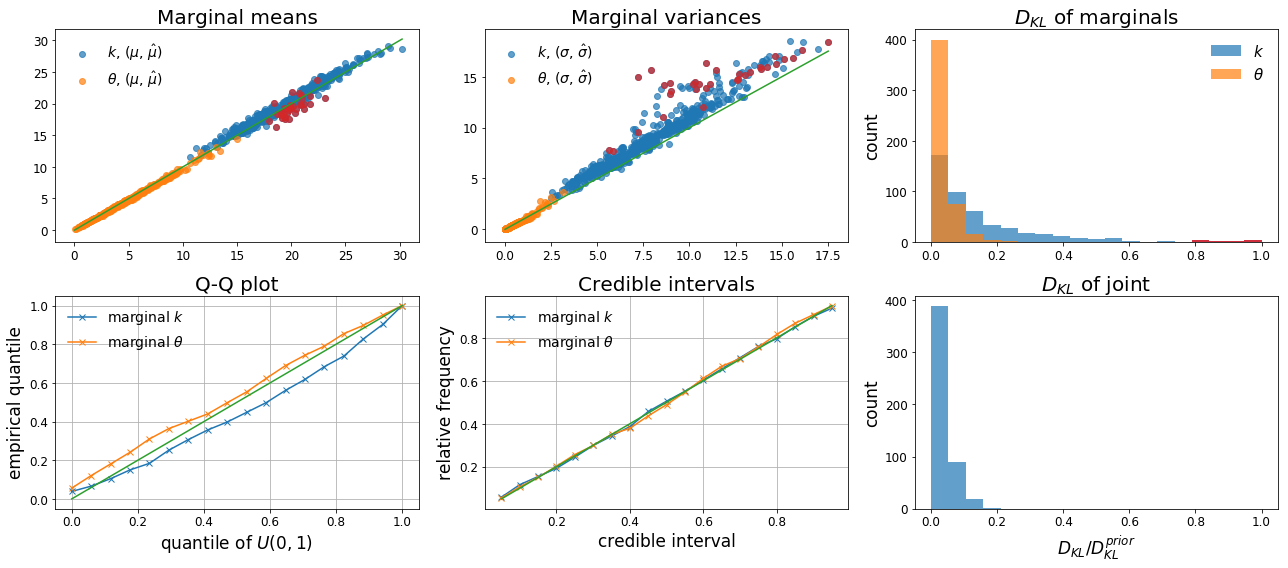

In [39]:
fig1, ax = plt.subplots(2, 3, figsize=(18, 8))
labels = [r'$k$', r'$\theta$']

dkl_bins = np.linspace(0, 1, 20)
alpha = .7

for i in range(2):
    line = np.linspace(mus_exact_zt[:, mask].min(), mus_exact_zt[:, mask].max(), 100)
    ax[0, 0].scatter(x=mus_exact_zt[i, mask], y=mus_hat_zt[i, mask], 
                     label=labels[i] + r', ($\mu$, $\hat{\mu}$)', alpha=alpha)
    
    if i == 0: 
        ax[0, 0].plot(line, line, 'C2')
        ax[0, 0].set_title('Marginal means')
    ax[0, 0].legend()

    line = np.linspace(stds_exact_zt[:, mask].min(), stds_exact_zt[:, mask].max(), 100)
    ax[0, 1].scatter(x=stds_exact_zt[i, mask], y=stds_hat_zt[i, mask], 
                     label=labels[i] + r', ($\sigma$, $\hat{\sigma}$)', alpha=alpha)
    if i == 0: 
        ax[0, 1].plot(line, line, 'C2')        
        ax[0, 1].set_title('Marginal variances')
    ax[0, 1].legend()
    
    # DKL
    n, dkl_bins, patches = ax[0, 2].hist(dkl_ratios[i, mask], bins=dkl_bins, 
                                  alpha=alpha, 
                                  label=labels[i]);
    # plot large dkl ratio    
    ax[0, 2].set_title(r'$D_{KL}$ of marginals')
    ax[i, 2].set_ylabel('count')
    if i == 1: 
        ax[1, 2].set_xlabel(r'$D_{KL} / D_{KL}^{prior}$')
        ax[1, 2].hist(dkl_ratios[2, mask], bins=dkl_bins, 
                                  alpha=alpha, 
                                  label='joint')
        ax[1, 2].set_title(r'$D_{KL}$ of joint')
        
    ax[0, 2].legend(fontsize=15)
    #                 label=r'$\frac{D_{KL}(p(\theta | x)||\hat{p}(\theta | x))}{ D_{KL}(p(\theta | x)||p_{prior}(\theta))}$', 
    
    
    n, bins = np.histogram(qis[i, mask], bins=credible_intervals)
    sample_quantiles = np.cumsum(n / np.sum(n))
    theo_quantiles = np.linspace(0, 1, len(n))
    ax[1, 0].plot(theo_quantiles, sample_quantiles, 'x-', label=r'marginal ' + labels[i])
    if i == 1:
        ax[1, 0].plot(theo_quantiles, theo_quantiles)
        ax[1, 0].grid()
        ax[1, 0].set_title('Q-Q plot')
    ax[1, 0].legend()
    ax[1, 0].set_ylabel('empirical quantile')
    ax[1, 0].set_xlabel(r'quantile of $U(0, 1)$')
    
    ax[1, 1].plot(credible_intervals, ci_probs_hat[i, ], 'x-', label=r'marginal ' + labels[i])
    if i==1:
        ax[1, 1].plot(credible_intervals, credible_intervals, '-')
        ax[1, 1].set_ylabel('relative frequency')
        ax[1, 1].set_xlabel('credible interval')
        ax[1, 1].grid()
        ax[1, 1].set_title('Credible intervals')
    ax[1, 1].legend()

# add plots for large dkl ratios    
i = 0
n, dkl_bins, patches = ax[0, 2].hist(dkl_ratios[0, largedkls_idx], bins=dkl_bins, 
                              alpha=alpha, color='r', 
                              label=labels[0]);
ax[0, 0].scatter(x=mus_exact_zt[i, largedkls_idx], y=mus_hat_zt[i, largedkls_idx], 
             label=labels[i] + r', ($\mu$, $\hat{\mu}$)', alpha=alpha, color='C3')
ax[0, 1].scatter(x=stds_exact_zt[i, largedkls_idx], y=stds_hat_zt[i, largedkls_idx], 
             label=labels[i] + r', ($\sigma$, $\hat{\sigma}$)', alpha=alpha, color='C3')
plt.tight_layout()

In [41]:
joint_prior = JointGammaPrior(prior_k, prior_theta)

In [42]:
largedkls_idx

for idx in largedkls_idx[:3]: 
    print(idx)
    mk, mth = ps[idx].get_marginals()
    mkh, mthh = ps_hat[idx].get_marginals()
#     plt.plot(mk.pdf_array, 'b')
#     plt.plot(mkh.eval_numpy(mk.support), 'r')
#     print(dkl_ratios[0, idx])
#     print(mk.mean, mkh.mean)
    ss = mk.gen(30000)
    post_samples = ps[idx].gen(20000)
    baseline, err = calculate_dkl_monte_carlo(np.array(ss), mk.pdf, prior_k.pdf)
    dkl, err = calculate_dkl_monte_carlo(np.array(ss), mk.pdf, mkh.eval_numpy)
    print(baseline, calculate_dkl_1D_scipy(mk.pdf_array, prior_k.pdf(mk.support)))
    print(dkl)
    print(dkl / baseline)
    
    baseline, err = calculate_dkl_monte_carlo(post_samples, ps[idx].pdf, joint_prior.pdf)
    print(baseline)
    dkl, err = calculate_dkl_monte_carlo(post_samples, ps[idx].pdf, ps_hat[idx].eval_numpy)
    print(dkl)
    print(dkl / baseline)
    
#     plt.plot(mth.pdf_array, 'b')
#     plt.plot(mthh.eval_numpy(mth.support), 'r')
#     plt.plot(mk.support, prior_k.pdf(mk.support))

2
0.123518410179 0.122206472079
0.130479526697
1.0563569148
4.42060982523
0.36526692963
0.0826281766703
11
0.0907798935902 0.055424346018
0.051243519305
0.564480936013
3.66873575897
0.189238059943
0.0515812727805
20
0.0767902952784 0.077485454361
0.211839494872
2.7586753522
7.54410082223
1.50498530763
0.199491674766


In [55]:
# use last index of loop above
post_exact = p
post_hat = ph
# calculate posterior again 
post_exact.calculated = False 
theta_o = d['params_test'][-1]
post_exact.calculat_exact_posterior(theta_o, 400, 1e-8)

x, y = np.meshgrid(post_exact.ks, post_exact.thetas)
pos = np.vstack((x.flatten(), y.flatten())).T
pdfh = post_hat.eval_numpy(pos).reshape(x.shape).T

calculating posterior: 100%|██████████| 160000/160000 [00:55<00:00, 2885.04it/s]


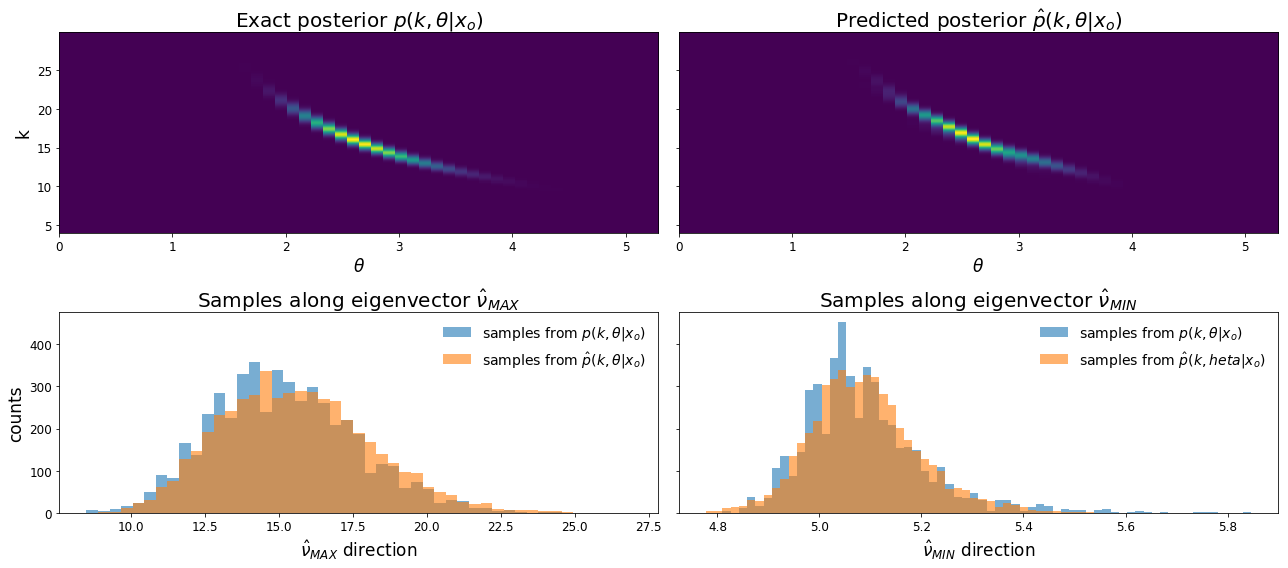

In [66]:
fig3, ax = plt.subplots(2, 2, figsize=(18, 8), sharey='row')

ki = 200
thi = 50
ax[0, 0].imshow(post_exact.joint_pdf[:ki, :thi], origin='lower', 
                extent=[post_exact.thetas[:thi].min(), post_exact.thetas[:thi].max(), 
                        post_exact.ks[:ki].min(), post_exact.ks[:ki].max()], aspect='auto')
ax[0, 0].set_title(r'Exact posterior $p(k, \theta | x_o)$')
ax[0, 0].set_xlabel(r'$\theta$')
ax[0, 0].set_ylabel(r'k')

ax[0, 1].imshow(pdfh[:ki, :thi], origin='lower', aspect='auto',  
                extent=[post_exact.thetas[:thi].min(), post_exact.thetas[:thi].max(), 
                        post_exact.ks[:ki].min(), post_exact.ks[:ki].max()])
ax[0, 1].set_title(r'Predicted posterior $\hat{p}(k, \theta | x_o)$')
ax[0, 1].set_xlabel(r'$\theta$')


n, bins, patch = ax[1, 0].hist(sp1, alpha=0.6, label=r'samples from $p(k, \theta | x_o)$', bins='auto');
ax[1, 0].hist(sph1, alpha=0.6, label=r'samples from $\hat{p}(k, \theta | x_o)$', bins=bins);
ax[1, 0].set_title(r'Samples along eigenvector $\hat{\nu}_{MAX}$')
ax[1, 0].legend()
ax[1, 0].set_ylabel('counts')
ax[1, 0].set_xlabel(r'$\hat{\nu}_{MAX}$ direction')

n, bins, patch = ax[1, 1].hist(sp2, alpha=0.6, label=r'samples from $p(k, \theta | x_o)$',
                               bins='auto');
ax[1, 1].hist(sph2, alpha=0.6, label='samples from $\hat{p}(k, \theta | x_o)$', bins=bins);
ax[1, 1].set_title(r'Samples along eigenvector $\hat{\nu}_{MIN}$');
ax[1, 1].set_xlabel(r'$\hat{\nu}_{MIN}$ direction')
ax[1, 1].legend()
plt.tight_layout();

In [ ]:
fig2, ax = plt.subplots(2, 4, figsize=(18, 6))

"# plt.suptitle('Means and stds of samples along eigenvector marginals', fontsize=20)\n
"# do everything for both eigenvectors \n
"labels = ['largest eig', 'smallest eig']\n
"for ii, lab in enumerate(labels):\n
"    # plot means\n
"    x = ev_meansh[ii, ]\n
"    y = ev_means[ii, ]\n
"    ax[ii, 0].scatter(x, y, label=lab, alpha=alpha)\n
"    ax[ii, 0].set_ylabel(r'true samples')\n
"    line = np.linspace(np.hstack((x, y)).min(), np.hstack((x, y)).max(), 100)\n
"    ax[ii, 0].plot(line, line, color='C1')\n
"    ax[ii, 0].legend()\n
"    ax[ii, 0].grid()\n
"    # title a top, xlabel at bottom\n
"    ax[0, 0].set_title('Sample means')\n
"    ax[1, 0].set_xlabel(r'estimated samples')\n
"    \n
"    # plot variances \n
"#     ax[0, 1].set_title('Sample variance')\n
"#     ax[1, 1].set_xlabel('estimated samples')\n
"#     ax[ii, 1].scatter(ev_stdsh[ii, ], ev_stds[ii, ], label=lab, alpha=alpha)\n
"#     line = np.linspace(ev_stds[ii, ].min(), ev_stds[ii, ].max(), 100)\n
"#     ax[ii, 1].plot(line, line, color='C1')\n
"#     ax[ii, 1].legend()\n
"#     ax[ii, 1].grid()\n
"    \n
"    # plot captured variance against estimated eigenvalues \n
"    colidx = 1\n
"    ax[0, colidx].set_title('Sample variance')\n
"    ax[1, colidx].set_xlabel('estimated samples')\n
"    x = ev_stdsh[ii, :]\n
"    y = ev_stds[ii, :]\n
"    ax[ii, colidx].scatter(x=x, y=y, label=lab, alpha=alpha)\n
"    line = np.linspace(np.hstack((x, y)).min(), np.hstack((x, y)).max(), 100)\n
"    ax[ii, colidx].plot(line, line, color='C1')\n
"    ax[ii, colidx].legend()\n
"    ax[ii, colidx].grid()\n
"\n
"    colidx = 2\n
"    ax[0, colidx].set_title('Captured variance')\n
"    ax[1, colidx].set_xlabel('true eigenvalue')\n
"    x = evls[ii, :]\n
"    y = ev_stds[ii, :]\n
"    ax[ii, colidx].scatter(x=x, y=y, label=lab, alpha=alpha)\n
"    line = np.linspace(np.hstack((x, y)).min(), np.hstack((x, y)).max(), 100)\n
"    ax[ii, colidx].plot(line, line, color='C1')\n
"    ax[ii, colidx].legend()\n
"    ax[ii, colidx].grid()\n
"    \n
"    colidx = 3\n
"    if ii == 0: \n
"\n
"        rowidx = ii\n
"        ax[0, colidx].set_title('Eigenvector angles')\n
"        ax[0, colidx].set_xlabel('angle difference [deg]')\n
"        x = angh[ii, ]\n
"        y = ang[ii, ]\n
"        ax[0, colidx].hist(angs, bins='auto')\n
"        ax[0, colidx].set_ylabel('count')\n
"#         ax[rowidx, colidx].scatter(x=x, y=y, alpha=alpha, label=lab)\n
"#         ax[rowidx, colidx].set_ylabel('true angle [deg]')\n
"#         line = np.linspace(np.hstack((x, y)).min(), np.hstack((x, y)).max(), 100)\n
"#         ax[rowidx, colidx].plot(line, line, color='C1')\n
"#         ax[rowidx, colidx].grid()\n
"#         ax[rowidx, colidx].legend()\n
"\n
"plt.tight_layout()"

In [ ]:
fn = time_stamp + 'posterior_checks_marginals_NB_ntrain{}_nsamples{}_ntest{}.png'.format(int(ntrain), 
                                                                                         int(100), 
                                                                                        int(ntest))
fig1.savefig(os.path.join('../figures', fn), dpi=300)

In [ ]:
fn = time_stamp + 'posterior_checks_eigenvectors_NB_ntrain{}_nsamples{}_ntest{}.png'.format(int(ntrain), 
                                                                                         int(100), 
                                                                                        int(ntest))
fig2.savefig(os.path.join('../figures', fn), dpi=300)

In [ ]:
fn = time_stamp + 'posterior_checks_examplejoint_NB_ntrain{}_nsamples{}_ntest{}.png'.format(int(ntrain), 
                                                                                         int(100), 
                                                                                        int(ntest))
fig3.savefig(os.path.join('../figures', fn), dpi=300)